Initial Data Load

In [9]:
%matplotlib inline
import seaborn as sns
sns.set_style("white")
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
datasource = pd.read_csv('https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

In [10]:
Z = pd.DataFrame(datasource.iloc[:,:].as_matrix(), columns = ['Customer','State','CustomerLifetimeValue','Response','Coverage','Education','EffectiveToDate','EmploymentStatus','Gender','Income','LocationCode','MaritalStatus','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','PolicyType','Policy','RenewOfferType','SalesChannel','TotalClaimAmount','VehicleClass','VehicleSize'])

In [11]:
X = Z[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]

In [12]:
y = Z[['CustomerLifetimeValue']]

Prepare Training & Test Data for Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

In [14]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [15]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, 
                                                                y_train_validation, 
                                                                test_size = 0.2, 
                                                                random_state = 0)

Model fitting process

In [15]:
current_MSE = ((y_train - y_train.mean())**2).mean()[0]
current_model_vars = set()
p = X_train.shape[1]

for k in range(p):
    possible_next_vars = list(set(range(p)) - current_model_vars)
    next_model_vars = current_model_vars
    for next_var in possible_next_vars:
        list(current_model_vars) + [next_var]
        model = LinearRegression().fit(X_train.iloc[:, list(current_model_vars) + [next_var]], y_train)
        model_validation_err = \
        ((model.predict(X_validation.iloc[:, list(current_model_vars) + [next_var]]) - y_validation)**2).mean()[0]
        if model_validation_err < current_MSE:
            next_model_vars = current_model_vars.union(set([next_var]))
            current_MSE = model_validation_err
    if next_model_vars == current_model_vars:
        break
    else:        
        print("Selecting ", str(X_train.columns[list(next_model_vars - current_model_vars)]))
        current_model_vars = next_model_vars

Selecting  Index(['MonthlyPremiumAuto'], dtype='object')
Selecting  Index(['NumberofOpenComplaints'], dtype='object')
Selecting  Index(['Income'], dtype='object')
Selecting  Index(['NumberofPolicies'], dtype='object')
Selecting  Index(['TotalClaimAmount'], dtype='object')
Selecting  Index(['MonthsSinceLastClaim'], dtype='object')


In [18]:
possible_next_vars

[3]

Final Model

In [19]:
X_train.columns[list(current_model_vars)]

Index(['Income', 'MonthlyPremiumAuto', 'MonthsSinceLastClaim',
       'NumberofOpenComplaints', 'NumberofPolicies', 'TotalClaimAmount'],
      dtype='object')

Checking Model Performance

In [20]:
model = LinearRegression().fit(X_train.iloc[:, list(current_model_vars)], y_train)
((model.predict(X_test.iloc[:, list(current_model_vars)]) - y_test)**2).mean()[0]

39180210.591260605

Adding variables one by one

In [22]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
Xpoly = StandardScaler().fit_transform(PolynomialFeatures(degree=2).fit_transform(X))

In [23]:
all_mse_train = []
all_mse_test = []
for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(Xpoly, y.as_matrix(), test_size = 0.1)
    mse_train = []
    mse_test = []
    for k in range(X_train.shape[1]):
        idx_vars = np.random.choice(range(X_train.shape[1]), size=k+1)
        lm = LinearRegression().fit(X_train[:, idx_vars], y_train)
        mse_train.append(((y_train - lm.predict(X_train[:, idx_vars]))**2).mean())
        mse_test.append(((y_test - lm.predict(X_test[:, idx_vars]))**2).mean())
    all_mse_train.append(mse_train)
    all_mse_test.append(mse_test)
all_mse_train = np.array(all_mse_train)
all_mse_test = np.array(all_mse_test)

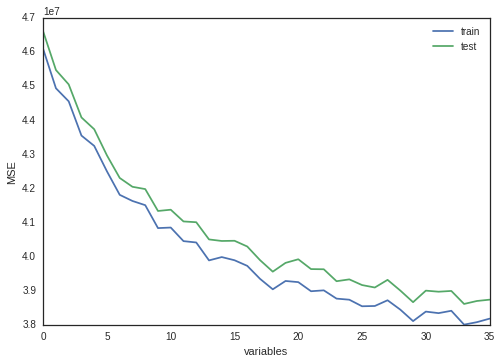

In [24]:
plt.plot(range(X_train.shape[1]), all_mse_train.mean(0), label='train');
plt.plot(range(X_train.shape[1]), all_mse_test.mean(0), label='test');
plt.legend();
plt.xlabel('variables');
plt.ylabel('MSE');

In [25]:
from sklearn.learning_curve import learning_curve

In [26]:
def MSE_score(estimator, X, y):
    return ((estimator.predict(X) - y)**2).mean()[0]

In [28]:
train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(), X[['Income']], y, scoring=MSE_score, cv  = 10)
train_sizes2, train_scores2, valid_scores2 = learning_curve(LinearRegression(), X, y, scoring=MSE_score, cv  = 10)

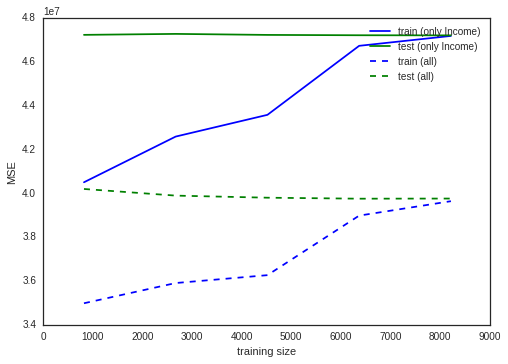

In [30]:
plt.plot(train_sizes, train_scores.mean(1), 'b', label='train (only Income)');
plt.plot(train_sizes, valid_scores.mean(1), 'g', label='test (only Income)');
plt.plot(train_sizes2, train_scores2.mean(1), 'b--', label='train (all)');
plt.plot(train_sizes2, valid_scores2.mean(1), 'g--', label='test (all)');
plt.legend();
plt.xlabel('training size');
plt.ylabel('MSE');

In [36]:
all_mse_test

array([[ 49923585.98215652,  56349438.91977616,  57159449.39251774, ...,
         50568078.87631189,  46526949.41905951,  50284959.41764388],
       [ 49606704.25078174,  51600270.28352112,  43407077.07796559, ...,
         40607959.71498693,  41832545.56244969,  39696573.1863092 ],
       [ 45135409.42542331,  48356756.49969601,  41972156.39883991, ...,
         34499566.71856602,  34698431.33183303,  38396389.48385132],
       ..., 
       [ 50905484.64870913,  46656559.09442812,  48683129.94444536, ...,
         42569789.26699869,  43447008.73304867,  43275306.07702187],
       [ 52872545.93221105,  52858935.45221642,  50300725.34149785, ...,
         43442636.82478888,  39281241.21454427,  40059930.76080453],
       [ 51560197.26288489,  50054658.03727667,  48753087.11753137, ...,
         44013365.86998851,  43654811.48214699,  39369503.54937446]])

Model Selection one by one Manually

Including all columns - 'Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount'

In [ ]:
import pandas as pd
datasource = pd.read_csv('https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')
Z = pd.DataFrame(datasource.iloc[:,:].as_matrix(), columns = ['Customer','State','CustomerLifetimeValue','Response','Coverage','Education','EffectiveToDate','EmploymentStatus','Gender','Income','LocationCode','MaritalStatus','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','PolicyType','Policy','RenewOfferType','SalesChannel','TotalClaimAmount','VehicleClass','VehicleSize'])
X = Z[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]
y = Z[['CustomerLifetimeValue']]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

In [ ]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, 
                                                                y_train_validation, 
                                                                test_size = 0.2, 
                                                                random_state = 0)

In [182]:
model1 = LinearRegression().fit(X_train[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']], y_train)

In [183]:
model1_train_err = ((model1.predict(X_train[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]) - y_train)**2).mean()[0]

In [184]:
model1_train_err

39173061.103578106

Removing Income

In [185]:
model1.predict(X_train[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']])

array([[  6348.40624385],
       [  8256.1772221 ],
       [ 10211.80608217],
       ..., 
       [  6580.61128937],
       [  9217.88127941],
       [  7335.50032318]])

In [56]:
model_Income = LinearRegression().fit(X_train[['MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']], y_train)
model_Income_train_err = ((model_Income.predict(X_train[['MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]) - y_train)**2).mean()[0]
model_Income_train_err

39194833.457941659

Removing Income increased Error
Now removing MonthlyPremiumAuto and putting Income back

In [57]:
model_MonthlyPremiumAuto = LinearRegression().fit(X_train[['Income','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']], y_train)
model_MonthlyPremiumAuto_train_err = ((model_MonthlyPremiumAuto.predict(X_train[['Income','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]) - y_train)**2).mean()[0]
model_MonthlyPremiumAuto_train_err

43572245.346640065

Removing MonthlyPremiumAuto increased Error drastically
Now removing MonthsSinceLastClaim and putting back MonthlyPremiumAuto

In [104]:
model_MonthsSinceLastClaim = LinearRegression().fit(X_train[['Income','MonthlyPremiumAuto','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']], y_train)
model_MonthsSinceLastClaim_train_err = ((model_MonthsSinceLastClaim.predict(X_train[['Income','MonthlyPremiumAuto','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]) - y_train)**2).mean()[0]
model_MonthsSinceLastClaim_train_err

39178435.140832938

In [106]:
y_train

,CustomerLifetimeValue
4843,16979.8
5941,3808.12
5871,8818.05
1215,7879.93
6383,7019.18
4167,2799.47
4158,5687.9
589,5295.74
8038,10004.7
5061,4883.12


Removing MonthsSinceLastClaim increased Error
Now removing MonthsSincePolicyInception and putting back MonthsSinceLastClaim

In [59]:
model_MonthsSincePolicyInception = LinearRegression().fit(X_train[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']], y_train)
model_MonthsSincePolicyInception_train_err = ((model_MonthsSincePolicyInception.predict(X_train[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]) - y_train)**2).mean()[0]
model_MonthsSincePolicyInception_train_err

39173338.163315758

Removing MonthsSincePolicyInception increased Error
Now removing NumberofOpenComplaints and putting back MonthsSincePolicyInception

In [61]:
model_NumberofOpenComplaints = LinearRegression().fit(X_train[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofPolicies','TotalClaimAmount']], y_train)
model_NumberofOpenComplaints_train_err = ((model_NumberofOpenComplaints.predict(X_train[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofPolicies','TotalClaimAmount']]) - y_train)**2).mean()[0]
model_NumberofOpenComplaints_train_err

39210771.955400094

Removing NumberofOpenComplaints increased Error
Now removing NumberofPolicies and putting back NumberofOpenComplaints

In [62]:
model_NumberofPolicies = LinearRegression().fit(X_train[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','TotalClaimAmount']], y_train)
model_NumberofPolicies_train_err = ((model_NumberofPolicies.predict(X_train[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','TotalClaimAmount']]) - y_train)**2).mean()[0]
model_NumberofPolicies_train_err

39195214.632313266

Removing NumberofPolicies increased Error
Now removing TotalClaimAmount and putting back NumberofPolicies

In [64]:
model_TotalClaimAmount = LinearRegression().fit(X_train[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies']], y_train)
model_TotalClaimAmount_train_err = ((model_TotalClaimAmount.predict(X_train[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies']]) - y_train)**2).mean()[0]
model_TotalClaimAmount_train_err

39187766.565644823

Removing TotalClaimAmount increased Error
So the best model is with all the features included

# Random Forest

In [2]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier

/usr/local/anaconda3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [ ]:
import pandas as pd
datasource = pd.read_csv('https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')
Z = pd.DataFrame(datasource.iloc[:,:].as_matrix(), columns = ['Customer','State','CustomerLifetimeValue','Response','Coverage','Education','EffectiveToDate','EmploymentStatus','Gender','Income','LocationCode','MaritalStatus','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','PolicyType','Policy','RenewOfferType','SalesChannel','TotalClaimAmount','VehicleClass','VehicleSize'])

In [420]:
Xrf = Z[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]
yrf = Z[['CustomerLifetimeValue']]

Remove Income

In [294]:
Xrf = Z[['MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]

Remove MonthlPremiumAuto

In [306]:
Xrf = Z[['Income','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]

Remove MonthsSinceLastClaim

In [318]:
Xrf = Z[['Income','MonthlyPremiumAuto','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]

Remove MonthsSincePolicyInception

In [330]:
Xrf = Z[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','NumberofOpenComplaints','NumberofPolicies','TotalClaimAmount']]

Remove NumberofOpenComplaints

In [342]:
Xrf = Z[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofPolicies','TotalClaimAmount']]

Remove NumberofPolicies

In [354]:
Xrf = Z[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','TotalClaimAmount']]

Remove TotalClaimAmount

In [366]:
Xrf = Z[['Income','MonthlyPremiumAuto','MonthsSinceLastClaim','MonthsSincePolicyInception','NumberofOpenComplaints','NumberofPolicies']]

In [421]:
Xrf_train_validation, Xrf_test, yrf_train_validation, yrf_test = train_test_split(Xrf, yrf, test_size = 0.1, random_state = 0)

In [422]:
Xrf_train, Xrf_validation, yrf_train, yrf_validation = train_test_split(Xrf_train_validation, 
                                                                yrf_train_validation, 
                                                                test_size = 0.2, 
                                                                random_state = 0)

In [423]:
from sklearn.ensemble import RandomForestRegressor

In [424]:
regressor = RandomForestRegressor(n_estimators=150)

In [425]:
regressor = regressor.fit(Xrf_train,yrf_train)

In [426]:
regressor.score(Xrf_train,yrf_train)

0.95653765955195502

In [427]:
predicted = regressor.predict(Xrf_test)

In [428]:
yrf_test_list = yrf_test['CustomerLifetimeValue'].tolist()

In [429]:
yrf_test_series = pd.Series(yrf_test_list)

In [430]:
mse = np.mean((regressor.predict(Xrf_test) - yrf_test_series)**2)

In [431]:
mse

12595402.202736666

In [432]:
importance = regressor.feature_importances_

In [433]:
importance[::-1]

array([ 0.07073568,  0.47028103,  0.01099797,  0.06240403,  0.06053917,
        0.26777215,  0.05726997])

In [434]:
importance

array([ 0.05726997,  0.26777215,  0.06053917,  0.06240403,  0.01099797,
        0.47028103,  0.07073568])

In [435]:
std = np.std([tree.feature_importances_ for tree in regressor.estimators_],
            axis=0)

In [436]:
indices = np.argsort(importance)[::-1]

In [437]:
indices

array([5, 1, 6, 3, 2, 0, 4])

In [438]:
Xrf_train.shape[1]

7

In [439]:
print("feature ranking:")

for f in range(Xrf_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))

feature ranking:
1. feature 5 (0.470281)
2. feature 1 (0.267772)
3. feature 6 (0.070736)
4. feature 3 (0.062404)
5. feature 2 (0.060539)
6. feature 0 (0.057270)
7. feature 4 (0.010998)


In [440]:
import matplotlib.pyplot as plt

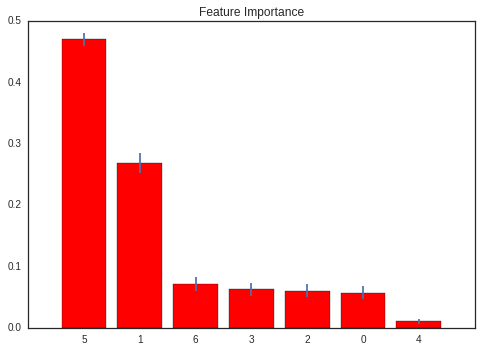

In [444]:
plt.figure()
plt.title("Feature Importance")
plt.bar(range(Xrf_train.shape[1]),importance[indices],
        color="r",yerr=std[indices],align="center")
plt.xticks(range(Xrf_train.shape[1]),indices)
plt.xlim([-1,X.shape[1]])
plt.show()

In [445]:
plt.savefig('feature.pdf')

In [452]:
yrf_test.to_csv('yrf_test.csv',sep=',')

In [451]:
np.savetxt('predicted.csv',predicted,delimiter=",")